## Juang Experiment

**System: 5 dof**

Modal properties (modal contributions and initial amplitudes are the same for each mode)

Mode | Frequency (Hz) | Damping Ratio (% of critical)
---- | -------------- | -----------------------------
1 | 0.159 | 1
2 | 0.318 | 1
3 | 0.477 | 1
4 | 0.636 | 1
5 | 0.795 | 1

**Data**

30 responses of 512 timesteps at 0.4s generated with 2% noise (RMS signal/noise)

**Results**

Mean damping ratio from ERA and ERA/DC - derived state space coefficients

In [1]:
import numpy as np
import scipy.linalg
import scipy.integrate
import matplotlib.pyplot as plt

import mdof
from mdof import modal as modes, realize
import sdof
from control.matlab import impulse as _impulse
def impulse(*args, **kwds):
    a,t = _impulse(*args, **kwds)
    return a.squeeze(),t 

In [2]:
frequencies = [0.159, 0.318, 0.477, 0.636, 0.795]
omegas = 2*np.pi*np.array(frequencies) # rad/s
zeta = 0.01
omegaDs = np.sqrt(1-zeta**2)*omegas
nt = 512
dt = 0.4
nModes = 5

M = np.eye(5)
C = 2*zeta*np.diag(omegas)
K = np.diag(omegas**2)

Ac = np.array(np.vstack((np.hstack((np.zeros(K.shape), np.eye(5))), np.hstack(([-K, -C])))))
Ad = scipy.linalg.expm(dt*Ac)
Bc = np.array([np.zeros(5), -np.ones(5)]).reshape((10,1))
def integrand(t):
    return scipy.linalg.expm(t*Ac) @ Bc
Bd, err = scipy.integrate.quad_vec(integrand,0,dt)
Cd = np.array(np.hstack([-K, -C]))
Dd = np.array(-np.ones(5)).reshape(5,1)

# import pandas as pd
# pd.DataFrame(Ac)
# plt.spy(Ac);
# plt.spy(Cd);
# print(Cd)
print(Bd)

[[-0.07873174]
 [-0.07543323]
 [-0.07031731]
 [-0.06370444]
 [-0.05599567]
 [-0.38788668]
 [-0.35590403]
 [-0.30714495]
 [-0.24619417]
 [-0.17861133]]


1.0 0.019980529276831086 0.9980538754557603
1.0 0.03996105855366217 3.992215501823041
1.0 0.05994158783049325 8.98248487910184
1.0 0.07992211710732434 15.968862007292165
1.0 0.09990264638415543 24.951346886394006


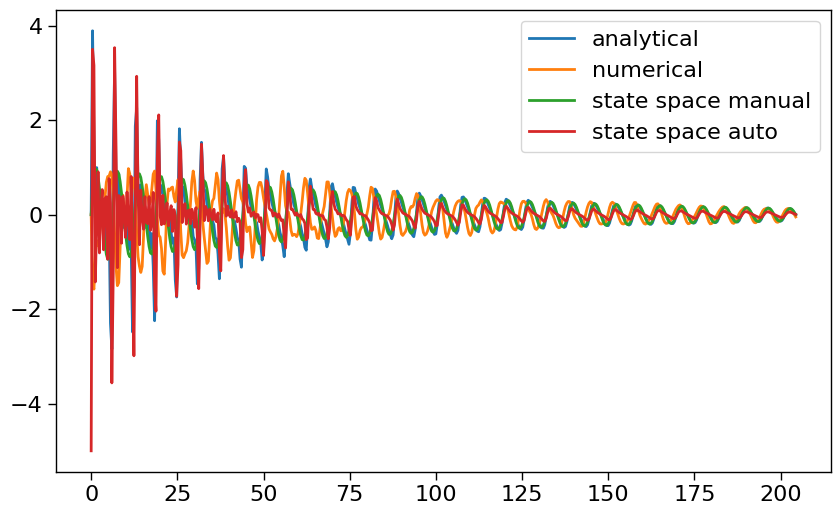

In [3]:
t = np.arange(start=0, stop=nt*dt, step=dt)

# Analytical Solution
# y_ana = np.array([-(np.exp(-omega*zeta*t))/omegaD * (np.sin(omegaD*t)) for omega,omegaD in zip(omegas,omegaDs)])
y_ana = np.array([(np.exp(-omega*zeta*t)) * (np.sin(omegaD*t)) for omega,omegaD in zip(omegas,omegaDs)])
Y_ana = np.array(y_ana).sum(axis=0)

# Numerical Integration
y_num = []
for i in range(5):
    print(M[i,i],C[i,i],K[i,i])
    u,v,a = sdof.integrate(M[i,i],C[i,i],K[i,i], np.zeros(nt), dt, v0=-1)
    y_num.append(u)
Y_num = np.array(y_num).sum(axis=0)

# Manually form impulse response from discrete state space model
x0 = np.array(np.hstack((np.zeros(5),1/omegas**2)))
xs = np.zeros((10,nt))
xs[:,0] = x0
for j in range(1,nt):
    xs[:,j] = Ad@xs[:,j-1]
y_ssm = xs[:5,:]
Y_ssm = np.array(y_ssm).sum(axis=0)

# Automatically form impulse response from discrete state space model using control.matlab package
Y_ssa = mdof.impulse((Ad,Bd,Cd,Dd), t)[0]
Y_ssa = Y_ssa.sum(axis=1)

# Plot to compare
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(t,Y_ana,label="analytical")
ax.plot(t,Y_num,label="numerical")
ax.plot(t,Y_ssm,label="state space manual")
ax.plot(t,Y_ssa,label="state space auto")
ax.legend();

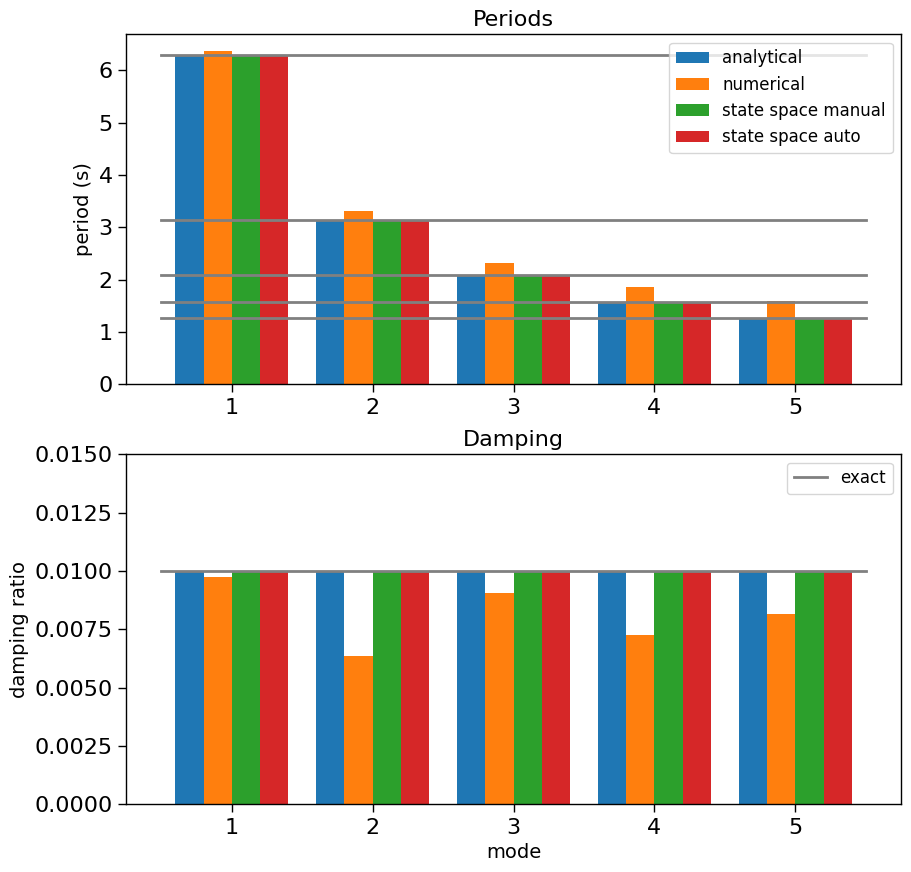

In [4]:
fig, ax = plt.subplots(2, 1, figsize=(10,10))
for f in frequencies:
    ax[0].plot([-0.2,4.8],[1/f,1/f], color="gray")
ax[1].plot([-0.2,4.8],[0.01,0.01], color="gray", label="exact")

labels = ["analytical", "numerical", "state space manual", "state space auto"]
thickness = [2, 2, 2, 2]
linetypes = ["-", "-", ":", "-"]

for i,y in enumerate([Y_ana, Y_num, Y_ssm, Y_ssa]):
    y = y[None,None,:]
    A,B,C,D = realize.era_dc(Y=y,r=10)
    mode_dict = modes.system_modes([A,B,C,D],dt)
    periods = [1/f for f in sorted([mode_dict[i]['freq'] for i in mode_dict.keys()])]
    width=0.2
    ax[0].bar(np.arange(5)+i*width, periods, width=width, label=labels[i])
    # ax[0].plot(periods, linewidth=thickness[i], linestyle=linetypes[i], label=labels[i])
    damping = [d for d in [mode_dict[i]['damp'] for i in mode_dict.keys()]]
    ax[1].bar(np.arange(5)+i*width, damping, width=width)
    # ax[1].plot(damping, linewidth=thickness[i], linestyle=linetypes[i], label=labels[i])
    ax[0].set_xticks(np.arange(nModes)+1.5*width)
    ax[0].set_xticklabels(np.arange(1,nModes+1))
    ax[1].set_xticks(np.arange(nModes)+1.5*width)
    ax[1].set_xticklabels(np.arange(1,nModes+1))

ax[0].set_title("Periods", fontsize=16)
ax[0].set_ylabel("period (s)", fontsize=14)
ax[0].legend(fontsize=12, loc="upper right")
ax[1].set_title("Damping", fontsize=16)
ax[1].set_ylabel("damping ratio", fontsize=14)
ax[1].set_xlabel("mode", fontsize=14)
ax[1].set_ylim([0,0.015])
ax[1].legend(fontsize=12);